# ゼロから始める簡単NNP

## NNPとは？？
Neural Network Potentialの略です。原子構造の情報を受け取って、エネルギーの値を予測する、ニューラルネットワークベースの機械学習モデルです。第一原理計算での構造とエネルギーの関係を再現するように、第一原理計算結果を使って学習させる仕組みを使っています。

この最も単純なケースを試してみましょう。今回扱うのは、結晶Siです。分子動力学法のトラジェクトリーを使って、様々な温度での熱ゆらぎが加わっていたり、密度が異なった状態での1250パターンの構造とエネルギーの情報を集めてあるので、それを学習データにします。

## 対称性関数の計算
構造とエネルギーの関係を学ばせるにあたって、まず構造をニューラルネットワーク的に扱いやすいデータに変換する必要があります。
その方法の一つが対称性関数です。詳細はRef[1]を見てもらうとして、ざっくりした説明としては、動径分布関数や角度の分布関数を工夫したようなものと考えておくと良いでしょう。

対称性関数はそこまでややこしい式ではないので、自力実装も可能ですが、近傍原子の判定などを効率よく書くのが難しいです。昔、私がpythonで自力で書いたものはとんでもなく遅かったので、最適化されているライブラリを使います。それが[DScribe](https://singroup.github.io/dscribe/latest/index.html)です。（最適化されているとはいえ、周期境界条件を入れると結構時間がかかるので、計算結果は保存しておくほうが効率が良いです）

In [1]:
from dscribe.descriptors import ACSF

nacsf=11
# Setting up the ACSF descriptor
acsf = ACSF(
    species=["Si"],
    rcut=7.0,
    g2_params=[[0.025,0.0], [0.05,0.0], [0.1,0.0],[0.2,0.0], [0.4,0.0],[0.8,0.0]],
    g4_params=[[0.1, 1.0, 1], [0.1, 4.0, 1], [0.1, 1.0, -1], [0.1, 4.0, -1]],
    periodic=True
)



用意してある計算結果を読み込んで処理します。xyzという第一原理計算やMDの業界でよく使う形式で、座標やエネルギーの値をまとめてあります。これをASEというパッケージの機能を使って処理しています。

In [2]:
from ase.io import iread
xyzfile='sample50.xyz'

import numpy as np

atoms=iread(xyzfile,index=':', format='extxyz')
nsample=1250
desc=np.zeros((nsample,64,nacsf))
label=np.zeros(nsample)



In [3]:
for ia, a in enumerate(atoms):


    all=np.arange(len(a.positions))

    acsf_Si = acsf.create(a)
    desc[ia,:,:]=acsf_Si
    label[ia]=a.get_total_energy()/64.0
    

In [4]:
desc.shape

(1250, 64, 11)

データがどんな形か確認してみましょう。descは計算された対称性関数の8つの値（最初の値は、G0と表記されるシンプルな動径分布に対応します）を保持していて、labelは系の原子あたりの平均エネルギーの情報を持っています。(全エネルギーそのままだと値が大きすぎるので)

In [5]:
desc[0,0,:], label[0]

(array([13.57160854,  9.17270279,  6.44236135,  3.49307561,  1.35376608,
         0.35307807,  0.03834928,  0.73605591,  0.43611127,  0.28210217,
         0.05149077]),
 -5.812224315)

In [6]:
desc[1,0,:], label[1]

(array([14.42732716,  9.91098404,  7.07846117,  3.96392226,  1.62639427,
         0.47494739,  0.06694016,  1.04516411,  0.59350401,  0.4443306 ,
         0.08542389]),
 -5.812822678125)

対称性関数の値にもそれなりにばらつきがありそうです。

このあと、ニューラルネットワークのフレームワークであるpytorchが扱いやすいように単精度に変換します。（機械学習フレームワークはだいたい単精度を使うことが多いです）

In [7]:
desc=np.float32(desc)
label=np.float32(label)

ニューラルネットワークの実装では配列の形を勘違いしてミスをすることが多いので確認しておきます

In [8]:
desc.shape, label.shape

((1250, 64, 11), (1250,))

使い回すために、numpyの機能でファイルに保存しておきます

In [9]:
np.save('desc',desc)
np.save('label',label)

本当はデータを正規化したほうが良いのですが、ひとまず単純に処理してみましょう

 ## ニューラルネットワークの定義
 今回は、ニューラルネットワークというと真っ先にイメージされる多層パーセプトロンを使います。

 このモデルでは、11の対称性関数の値を受け取って、それをノード数20の隠れ層に渡し、最終的に一つの出力を得る形になっています。
 この出力は「原子ひとつあたりのエネルギー」に相当すると考えます。原子ひとつあたりのエネルギーがきちんと定義できるのかはさておき、それらを足し上げると、系の全エネルギーになるようにネットワーク中の重みやバイアスを最適化していきます。

In [10]:
import torch.nn as nn
import torch
import torch.optim as optim

#対称性関数の入力は8次元、隠れ層のノード数は20、3層で出力は１のネットワーク

class Net(nn.Module):
    #n_sf : number of symmetry function
    #two-hidden layer
    #output is energy per atom
    def __init__(self,n_sf,n_hidden):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(n_sf, n_hidden)
        self.a1  = nn.Tanh()
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.a2  = nn.Tanh()
        self.fc3 = nn.Linear(n_hidden,1)

        #for debug backprop
        self.fc1mask=[]
        self.fc2mask=[]

        #He initialization
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        nn.init.kaiming_normal_(self.fc3.weight)
        self.results={}

        self.layers=[self.fc1, self.a1, self.fc2, self.a2, self.fc3]

    #relu actination function
    #two hidden layer
    #evaluate eneergy & derivative in forward run
    def forward(self,x):

        for layer in self.layers:
            x=layer(x)

        return x

## 学習データとテストデータの分割
機械学習では過学習（使ったデータにはよく合うが、それ以外のデータにはうまく対応できない）がつきものなので、汎化性能を調べるために、学習データとテストデータの分割を行います。今回は8割を学習データ、2割をテストデータにします。

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(desc, label, test_size=0.2)

pytorchはテンソルを入力として受け取り、出力もテンソルにすることができます。上記のseq_modelは8つの要素を持つベクトルを受け取ることを前提にかかれていますが、それが積み上がってテンソルになった入力に対しても柔軟に処理することができます。イメージ的に分かりにくいので、実際にやってみましょう。

In [12]:
#データ処理の概要確認
#テンソルとしてデータを一気に流し込み、原子数の次元で和を取る
model=Net(n_sf=nacsf,n_hidden=20)
test_out=model(torch.tensor(X_train))
test_out.shape

torch.Size([1000, 64, 1])

1000データがあって、それぞれに（64,1）の配列が格納されている形式になっています。この64というのは原子数で、実際の正解データと比較するのは、64原子分の総和をとった値です。それは以下のようにして計算できます。

In [23]:
p_energy=torch.sum(test_out, dim=1)
p_energy.shape


torch.Size([1000, 1])

## 学習部分のコード

これはとてもシンプルにするために、各エポックで全部のデータについての予測値が出揃ってから更新をかけています。効率が悪いです。本来はミニバッチをつかって、更新頻度を高くして効率よく学習させます（データローダーを書くのが面倒なので暫定版）

In [14]:
def training_loop(n_epochs, optimizer, model, loss_fn, X_train, y_train, X_test, y_test):
    for epoch in range(1, n_epochs+1):
        tmp=model(X_train)
        p_train=torch.sum(tmp, dim=1)/64.0

        loss_train=loss_fn(p_train, y_train)
        
        p_val= torch.sum(model(X_test),dim=1)/64.0
        loss_val=loss_fn(p_val, y_test)
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
        if epoch == 1 or epoch %10 ==0:
            print('Epoch %d, Training Loss %f' %(epoch, loss_train))
            print('\t Validation Loss %f' %(loss_val))
    return 

torchのtensor型に変換します。y_train, y_testはモデルの出力と整合させるために、unsqueeze(1)で余分な次元をつけています

In [15]:
X_train=torch.tensor(X_train)
X_test=torch.tensor(X_test)
y_train=torch.tensor(y_train).unsqueeze(1)
y_test=torch.tensor(y_test).unsqueeze(1)

In [16]:
optimizer=optim.Adam(model.parameters(), lr=0.001)

In [24]:
training_loop(n_epochs=10000, optimizer=optimizer,model=model,
             loss_fn=nn.MSELoss(), X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

Epoch 1, Training Loss 0.000283
	 Validation Loss 0.000310
Epoch 10, Training Loss 0.000283
	 Validation Loss 0.000310
Epoch 20, Training Loss 0.000283
	 Validation Loss 0.000310
Epoch 30, Training Loss 0.000282
	 Validation Loss 0.000309
Epoch 40, Training Loss 0.000282
	 Validation Loss 0.000309
Epoch 50, Training Loss 0.000282
	 Validation Loss 0.000309
Epoch 60, Training Loss 0.000309
	 Validation Loss 0.000330
Epoch 70, Training Loss 0.000294
	 Validation Loss 0.000315
Epoch 80, Training Loss 0.000307
	 Validation Loss 0.000325
Epoch 90, Training Loss 0.000286
	 Validation Loss 0.000308
Epoch 100, Training Loss 0.000282
	 Validation Loss 0.000307
Epoch 110, Training Loss 0.000281
	 Validation Loss 0.000307
Epoch 120, Training Loss 0.000281
	 Validation Loss 0.000308
Epoch 130, Training Loss 0.000281
	 Validation Loss 0.000307
Epoch 140, Training Loss 0.000280
	 Validation Loss 0.000307
Epoch 150, Training Loss 0.000280
	 Validation Loss 0.000307
Epoch 160, Training Loss 0.000280
	

正解と予測結果をプロットしてみましょう

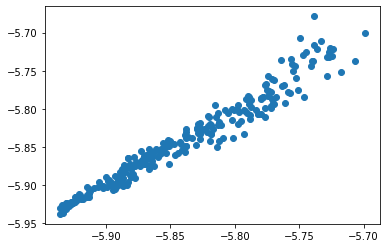

In [25]:
import matplotlib.pyplot as plt
model.eval()
with torch.no_grad():
    predict=torch.sum(model(X_test),dim=1)/64.0
    #plt.xlim((-6,-5.6))
    #plt.ylim((-6,-5.6))
    plt.scatter(y_test,predict)